   ## Import libraries

In [1]:
from rooftop.rooftop import RooftopProc
from rooftop.s3utils import S3Helper

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


   ## 1. Set variables and parameters

In [3]:
# Paths and file names
bucket_name = 'roof-index'
main_dir = 'austin/geospatial/'  # Main directory to read and write from in S3 bucket.
dsm_fname = 'austin_dsm.tif'
hfdem_fname = 'austin_dem.tif'
bldgs_fname = 'bldg_footprint.zip'
bldgs_id = 'fid'  # Name of the unique id used in the buildings shapefile 
slope_fname = 'test_slope.tif'  # Does not exist. This is the name of the file to be written.
height_fname = 'test_height.tif'  # Does not exist. This is the name of the file to be written.
flat_area_fname = 'test_flat_area_bldgs.zip'  # Does not exist. This the name of the file to be written.

# Paths and file names
# bucket_name = 'roof-index'
# main_dir = 'missoula/geospatial/'  # Main directory to read and write from in S3 bucket.
# dsm_fname = 'downtown_dsm.tif'
# hfdem_fname = 'downtown_hfdem.tif'
# bldgs_fname = 'downtown_bldgs.zip'
# bldgs_id = 'fid'  # Name of the unique id used in the buildings shapefile 
# slope_fname = 'test_slope.tif'  # Does not exist. This is the name of the file to be written.
# height_fname = 'test_height.tif'  # Does not exist. This is the name of the file to be written.
# flat_area_fname = 'test_flat_area_bldgs.zip'  # Does not exist. This the name of the file to be written.

# Parameters
pitch_slope_threshold = 11  # Max. slope (degrees) to which we consider roof to be flat.
pitch_area_threshold = 9  # Min. percentage of flat area on a roof to be classified as flat.
fa_slope_threshold = 45  # Max. value of slope for flat area disaggregation
fa_area_threshold = 93.903  # Min. area in m^2 for flat area disaggregation


   ## 3. Instantiate S3 and Rooftop objects

In [4]:
S3 = S3Helper(bucket_name)
Rooftop = RooftopProc(S3, main_dir, dsm_fname, hfdem_fname, bldgs_fname, bldgs_id)

   ## 4. Create slope and height arrays and upload to S3 as geotiffs

In [5]:
slope_arr = Rooftop.create_slope_arr(slope_fname) 
height_arr = Rooftop.create_height_arr(height_fname)

test_slope.tif has been successfully written to your S3 bucket.
test_height.tif has been successfully written to your S3 bucket.


   ## 5. Filter out pitched roofs from bldgs dataframe

In [6]:
flat_bldgs = Rooftop.pitched_roof_filter(pitch_area_threshold, pitch_area_threshold)

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1097: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


   ## 6. Disaggregate building footprints into flat areas

In [7]:
disagg_bldgs = Rooftop.flat_area_disaggregator(flat_bldgs, fa_slope_threshold, fa_area_threshold, flat_area_fname)

Creating polygons from raster data. Hang on, this may take a bit.
test_flat_area_bldgs.zip has been successfully written to your S3 bucket.


   ## 7. Add rooftop features
 Features list below can include:

 - 'average_slope'
 - 'height'
 - 'parapet'
 - 'closeness_to_points'
 - 'volume_on_roof'

In [8]:
features = ['average_slope', 'height', 'parapet', 'volume_on_roof']
ctp_paths = ['test_greenspaces.zip', 'test_groceries.zip']
full_features = Rooftop.feature_builder(disagg_bldgs, features, ctp_paths=ctp_paths)

Adding average slope feature now.
Adding median height feature now.
Adding parapet feature now.
Adding volume on roof feature now.


   ## 8. Create index

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/rooftop/s3utils.py:106: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(filename=tempdir + fname, driver='ESRI Shapefile')


main_index.zip has been successfully written to your S3 bucket.


(620184.6936247362, 622319.0145892983, 3348168.8322650543, 3351890.5224338565)

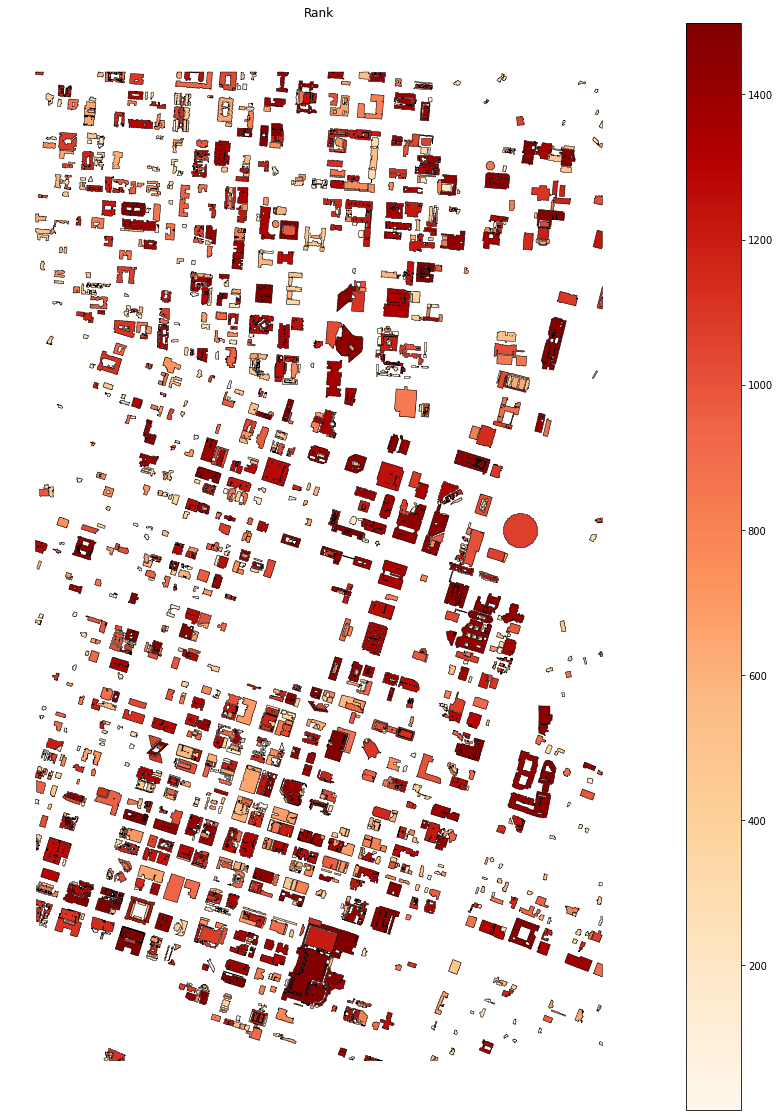

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd

wts = [(1/7) * 2, 1/7, (1/7) / 2, (1/7) / 2, (1/7) / 2, (1/7) / 2, (1/7) * 2]
mcda = Rooftop.index_builder(full_features, None)
mcda = gpd.GeoDataFrame(mcda)
ax = mcda.plot(column="vul_rank", cmap='OrRd', legend=True, figsize=[20,20], edgecolor='k', linewidth=0.5)
ax.set_title('Rank')
ax.axis('off')

In [9]:
from sklearn.preprocessing import MinMaxScaler
from skcriteria import Data, MIN
from skcriteria.madm import closeness
import geopandas as gpd

wts = None

mcda = full_features.copy()
geom = mcda['geometry']

mcda = mcda.set_index('faid')
mcda = mcda[[x[0] for x in Rooftop.col_names]]

orig_cols = []
tmp_cols = []
for cname, inv in Rooftop.col_names:
    orig_cols.append(cname)
    tmp_cols.append(cname+'_tmp')
    mcda[cname+'_tmp'] = Rooftop.rescale(mcda[cname], inv)


mcda_tmp = mcda[tmp_cols].rank(method='min')
crit = [MIN] * len(mcda_tmp.columns)

if not wts:
    wts = [1/len(mcda_tmp.columns)] * len(mcda_tmp.columns)

mca_data = Data(mcda_tmp.values, crit, anames=mcda_tmp.index, cnames=mcda_tmp.columns, weights=wts)

dm = closeness.TOPSIS()
dec = dm.decide(mca_data)

mcda['vulnerability'] = dec.e_.closeness
mcda['vul_rank'] = dec.rank_
mcda['geometry'] = geom
mcda = mcda.drop(columns=tmp_cols)
mcda = gpd.GeoDataFrame(mcda) if not isinstance(mcda, gpd.GeoDataFrame) else mcda
Rooftop.S3.write_gdf_to_s3(mcda, Rooftop.main_dir + 'main_index.zip')

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/rooftop/s3utils.py:106: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(filename=tempdir + fname, driver='ESRI Shapefile')


main_index.zip has been successfully written to your S3 bucket.


(1/7) * 2

In [10]:
wts = None

In [11]:
mcda

,flat_area,avg_slope,height,parapet_slope,volume,vulnerability,vul_rank,geometry
faid,,,,,,,,
0,416.403833,16.306861,4.381508,33.014946,0.464996,0.472869,1112,"POLYGON Z ((620286.000 3349306.000 0.000, 6202..."
1,532.304734,7.916113,11.920509,54.323982,0.000000,0.521604,964,"POLYGON Z ((620741.000 3349268.000 0.000, 6207..."
2,108.891750,18.242077,7.877502,54.323982,0.000000,0.698880,104,"POLYGON Z ((620731.000 3349271.000 0.000, 6207..."
3,352.000000,14.511742,13.735001,54.323982,0.000000,0.591555,610,"POLYGON Z ((620729.000 3349250.000 0.000, 6207..."
4,110.137775,16.617775,7.602997,54.323982,0.000000,0.693149,127,"POLYGON Z ((620769.000 3349258.000 0.000, 6207..."
...,...,...,...,...,...,...,...,...
1494,202.505288,11.284523,25.426987,73.949730,0.000000,0.614079,472,"POLYGON Z ((620635.000 3348882.000 0.000, 6206..."
1495,332.474539,11.177691,25.955002,73.949730,0.000000,0.587832,633,"POLYGON Z ((620619.000 3348877.000 0.000, 6206..."
1496,355.027426,12.754947,25.477997,73.949730,0.000000,0.600257,566,"POLYGON Z ((620671.000 3348871.000 0.000, 6206..."
